<a href="https://colab.research.google.com/github/YazCodes/heartRatePrediction/blob/main/ARIMA_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy import linalg
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
#from quantecon import Kalman, LinearStateSpace
from scipy.stats import norm
from scipy.integrate import quad
from numpy.random import multivariate_normal
from scipy.linalg import eigvals
from scipy import signal
from sklearn.decomposition import FastICA, PCA
from numpy import dot
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Load the data 
df = pd.read_csv("PT_Train.csv")
df.head(20) #first 20 data points
df.tail() #looking at the last minutes of heartrate and where to start the prediction  

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
221,17/08/2015 18:50,159,51,NaN,NaN
222,17/08/2015 18:51,151,64,NaN,NaN
223,17/08/2015 18:52,140,64,NaN,NaN
224,17/08/2015 18:53,140,55,NaN,NaN
225,17/08/2015 18:54,138,54,NaN,NaN


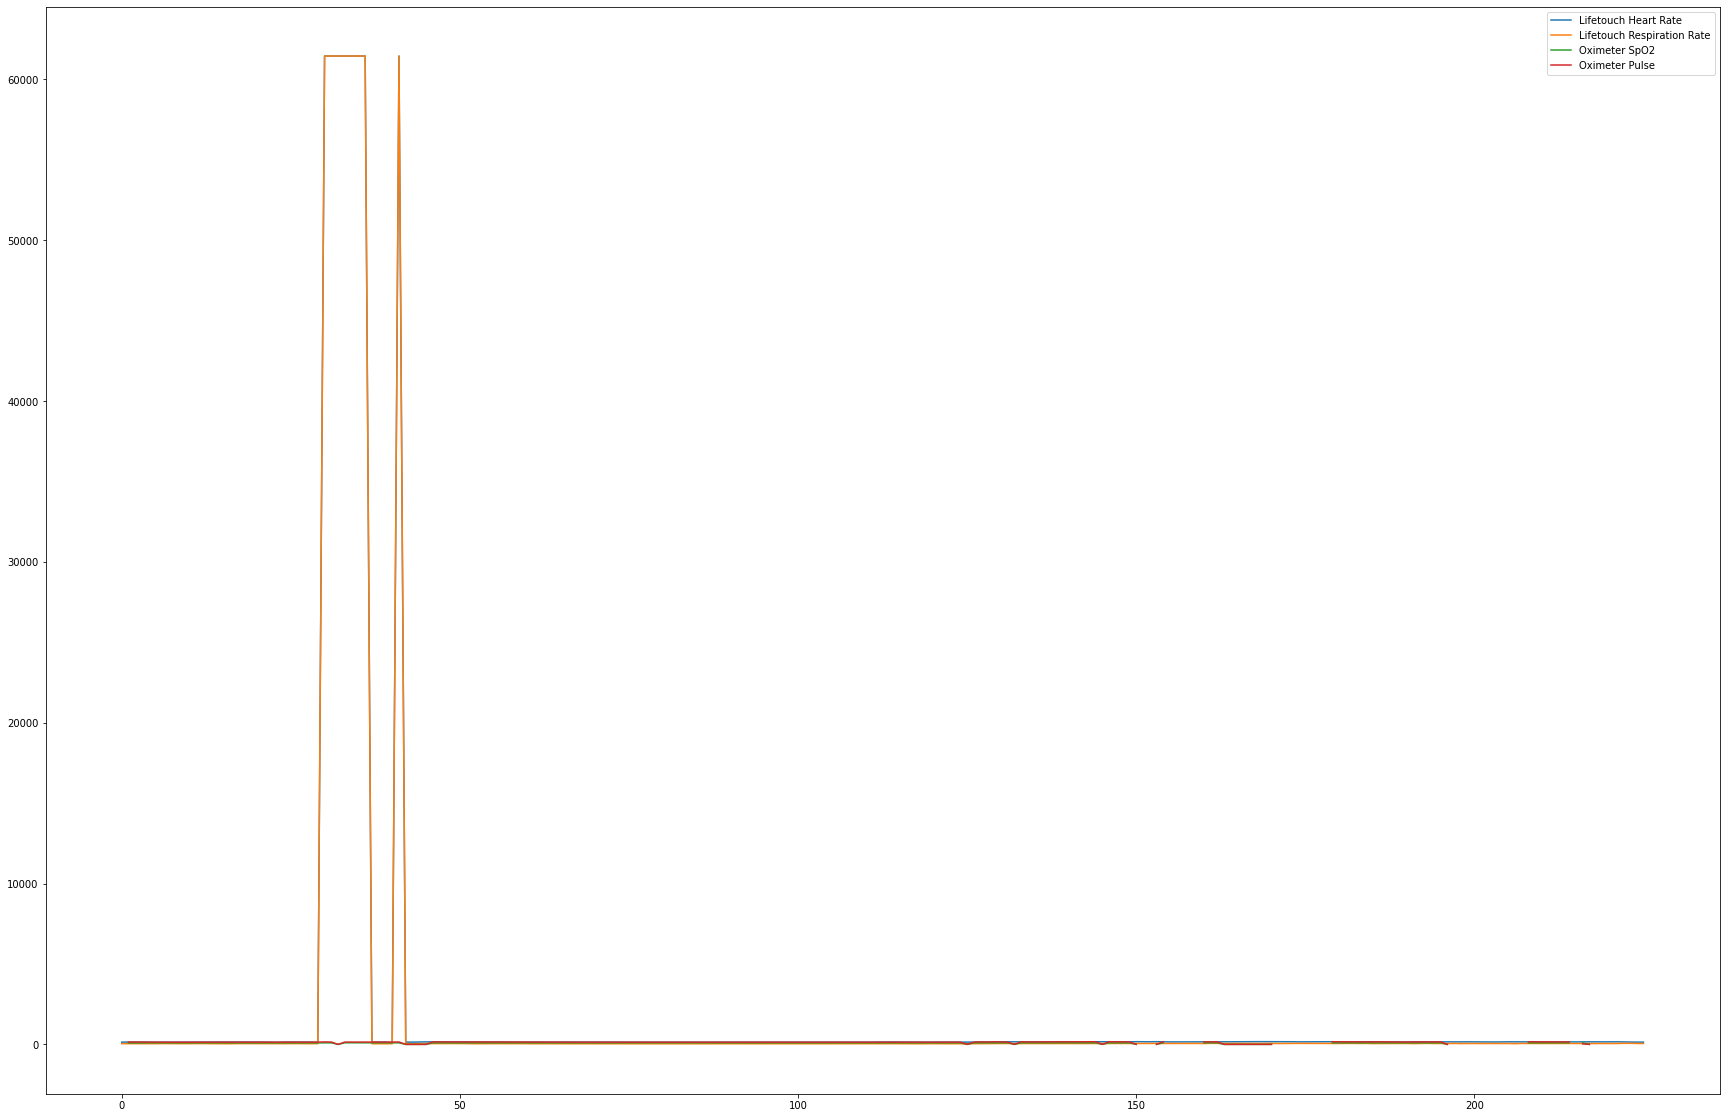

In [3]:
#Plot our data
df = pd.read_csv("PT_Train.csv")


matplotlib.rc('figure', figsize=(30, 20))
df.plot()

In [6]:
#Data cleaning  - Important step as the ML model and data processing cannot start if the dataset contains missing values

df.isnull().values.any() #This shows if there are any missing values in the dataset. True = yes false = No

df = df.dropna() #drop any rows with missing values 

df= df.drop(['Lifetouch Respiration Rate', 'Oximeter SpO2','Oximeter Pulse'], axis= 'columns')

print(f'Number of entries: {len(df)}') #check if the number of entries have changed

Number of entries: 191


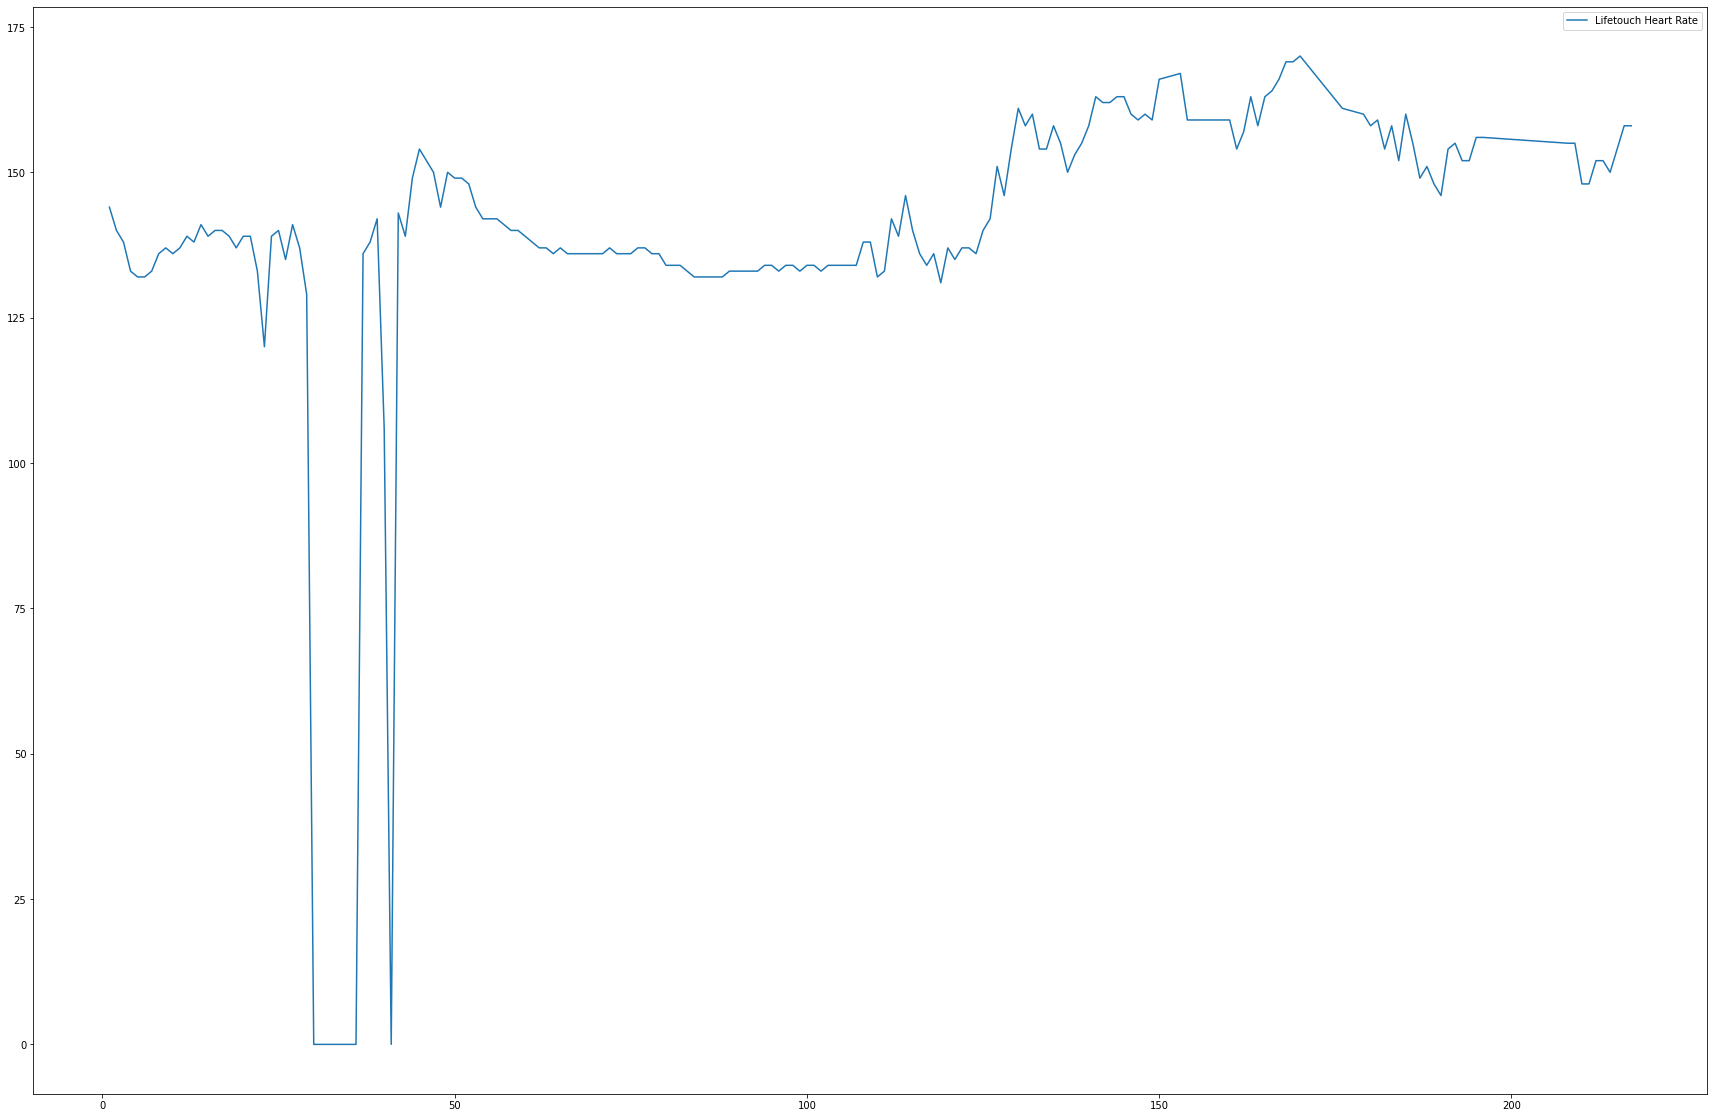

In [7]:
#Cut off function
def cutoff(row):
    vals = row
    if vals>1000:
        vals = 0  #Any value > 1000 will be set to 0 
    return vals

matplotlib.rc('figure', figsize=(30, 20))
df['Lifetouch Heart Rate'] = df['Lifetouch Heart Rate'].apply(cutoff)
df.plot()

In [8]:
#Data cleaning continued 
print("Number of null values:")
print(sum(df['Lifetouch Heart Rate'].isnull()))
print("Number of N\A values:")
print(sum(df['Lifetouch Heart Rate'].isna()))
print("Number of low values (>2000):")
print(sum(df['Lifetouch Heart Rate']> 2000)) 

df.isnull().values.any()

Number of null values:
0
Number of N\A values:
0
Number of low values (>2000):
0


False

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)



Result: the time series is not stationary



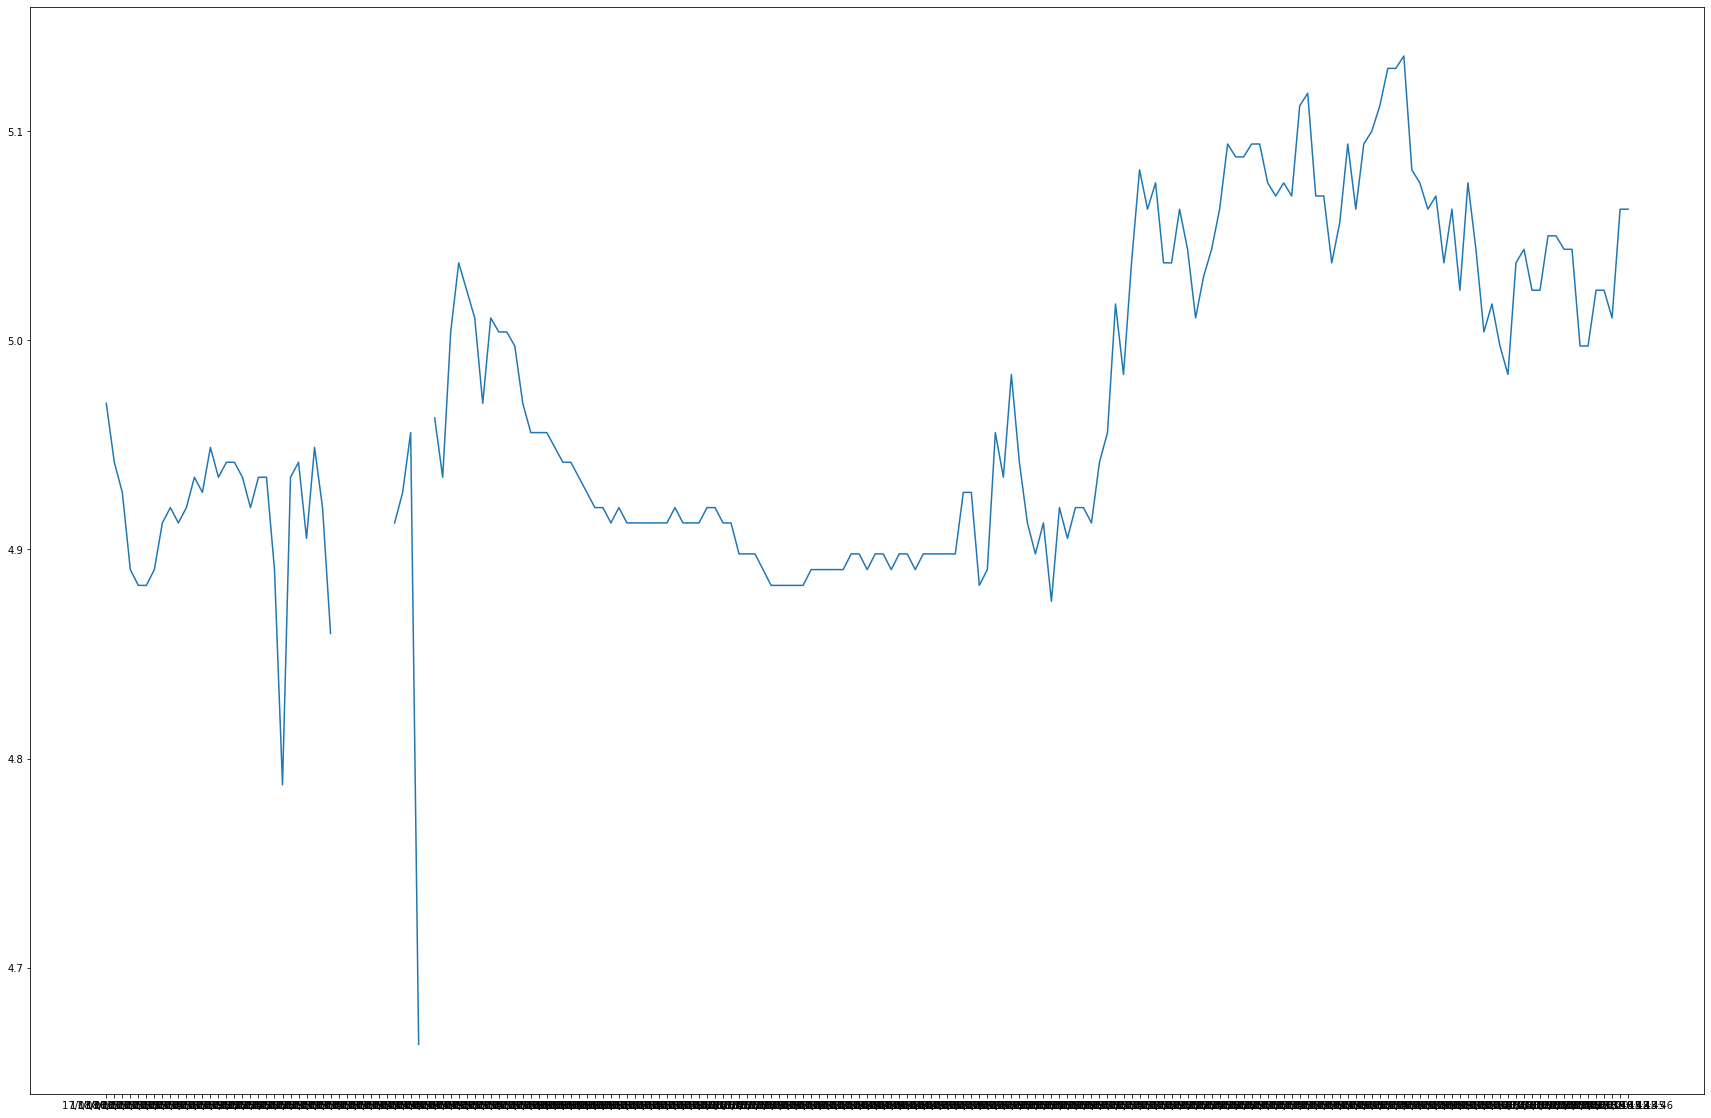

,Timestamp (GMT),Lifetouch Heart Rate,stationary
1,17/08/2015 15:10,144,4.969813
2,17/08/2015 15:11,140,4.941642
3,17/08/2015 15:12,138,4.927254
4,17/08/2015 15:13,133,4.890349
5,17/08/2015 15:14,132,4.882802


In [9]:
#Step one - check if data is stationary using the KPSS test 
df['stationary'] = np.log(df['Lifetouch Heart Rate'])

statistic,p_value,n_lags,critical_values= sm.tsa.stattools.kpss(df['Lifetouch Heart Rate'])
print(f'\nResult: the time series is {"not" if p_value <0.05 else""} stationary\n')

plt.plot(df['Timestamp (GMT)'],df['stationary'])
plt.show()
df.head()

In [11]:

mons = df.pop('Timestamp (GMT)')
u = df.iloc[1]['stationary'] # swap around the order 
df=df.diff(axis=0,periods=12) # every 1st and 12th row it does what is being asked then 14th 2nd - accounts for the peaks 

plt.plot(np.linspace(1,131,213),df['stationary'][13:])
plt.show()

KeyError: ignored

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)



Result: The series is stationary



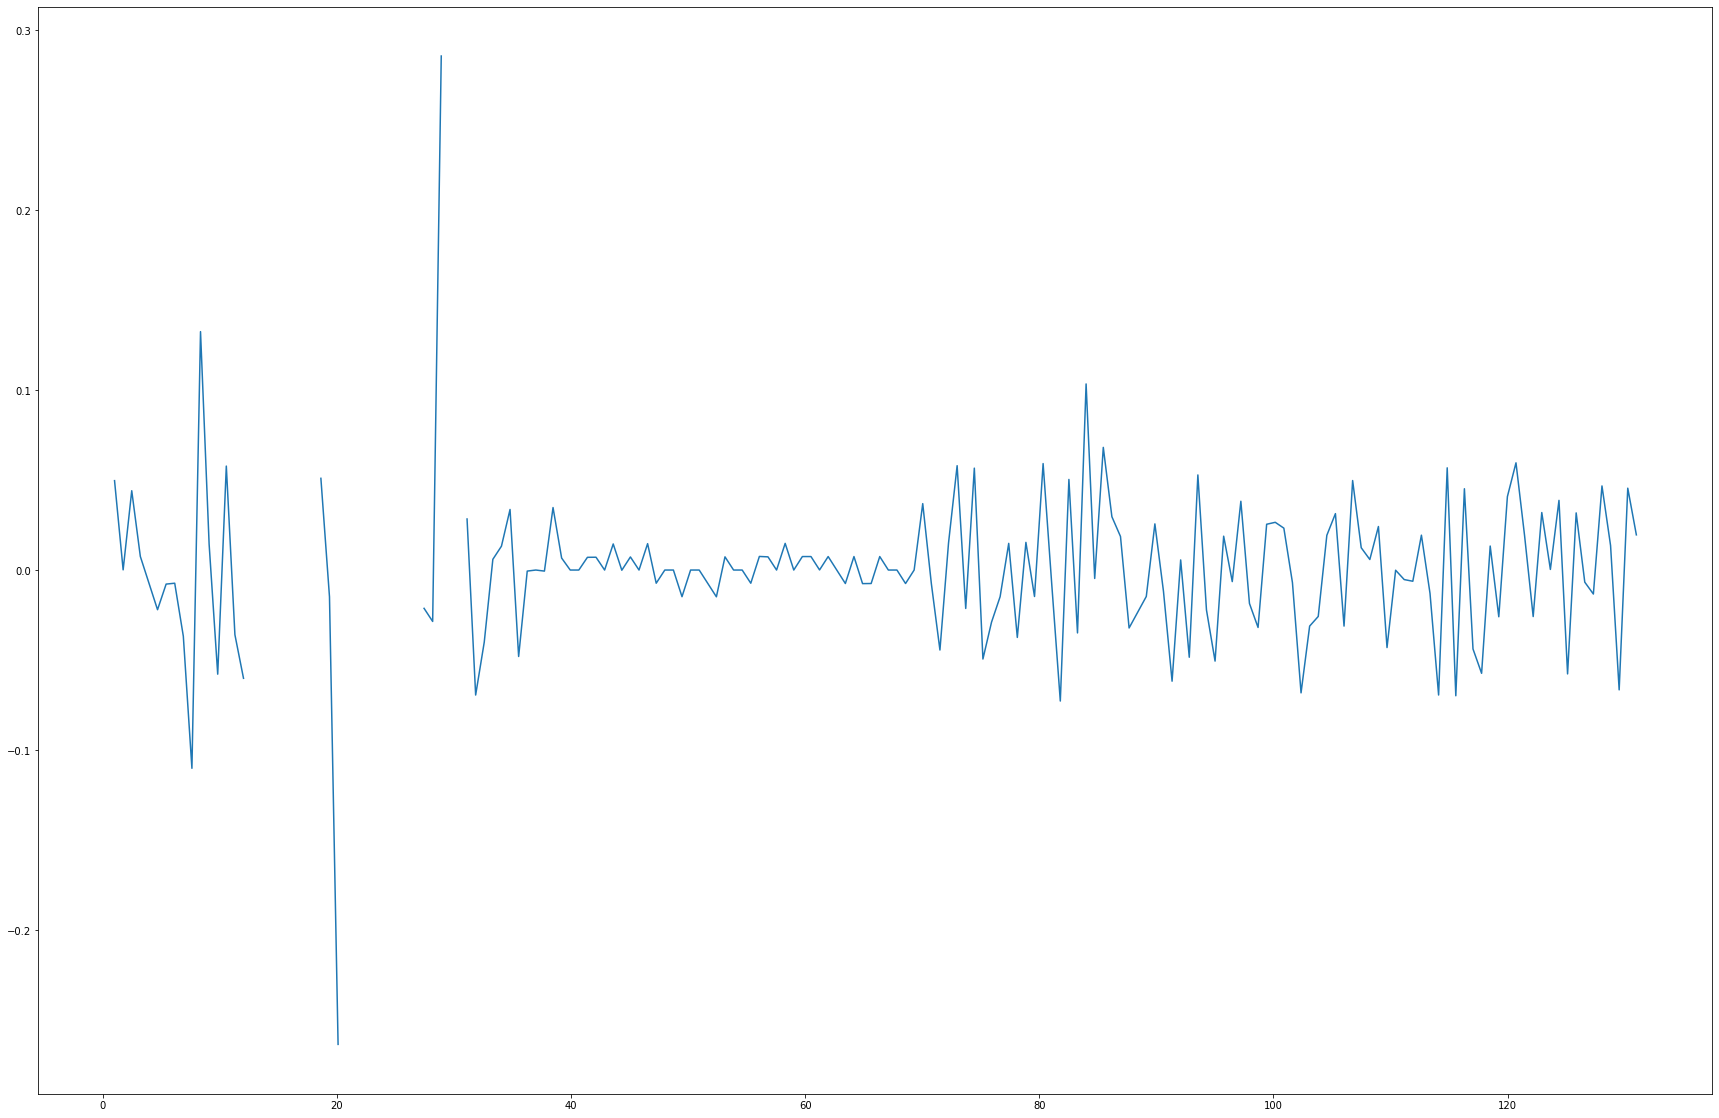

,Lifetouch Heart Rate,stationary
212,7.0,0.046736
213,2.0,0.013606
214,-10.0,-0.066591
216,7.0,0.045487
217,3.0,0.019545


In [12]:
u = df.iloc[13]['stationary']
df = df.diff(axis=0)

statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(df['stationary'])
print(f'\nResult: The series is {"not " if p_value < 0.05 else ""}stationary\n')

plt.plot(np.linspace(1,131,178),df['stationary'][13:])
plt.show()
df.tail()

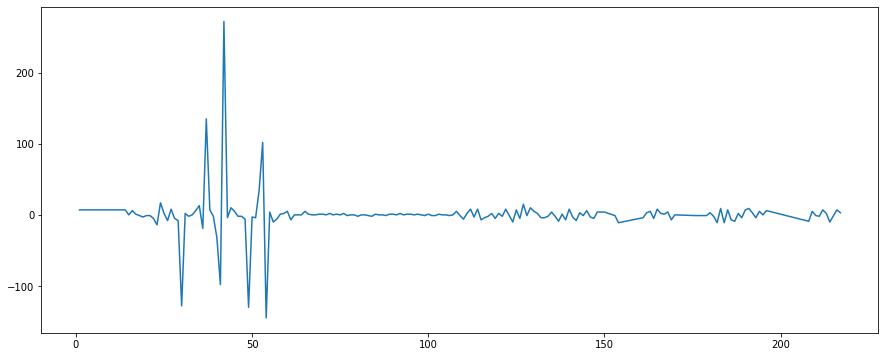

In [13]:
#ARIMA model 
 
y = df['Lifetouch Heart Rate'] #plot only the heartrate data 


y = y.fillna(y.bfill())
y.plot(figsize=(15, 6))

In [14]:
import itertools
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq = [(0, 0, 0, 0)]  # change to 0000 - As the data is not affected by seasonality 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

#Result - ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:1802.3279590001505

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was pro

ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:1837.0761557630585
ARIMA(0, 0, 1)x(0, 0, 0, 0)12 - AIC:1820.1718938245385
ARIMA(0, 0, 2)x(0, 0, 0, 0)12 - AIC:1812.391423461423
ARIMA(0, 1, 0)x(0, 0, 0, 0)12 - AIC:1995.5153685714054
ARIMA(0, 1, 1)x(0, 0, 0, 0)12 - AIC:1826.2500802804086


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 2)x(0, 0, 0, 0)12 - AIC:1809.7164907193387
ARIMA(0, 2, 0)x(0, 0, 0, 0)12 - AIC:2201.4442208669698
ARIMA(0, 2, 1)x(0, 0, 0, 0)12 - AIC:1982.557279428947
ARIMA(0, 2, 2)x(0, 0, 0, 0)12 - AIC:1819.9133897733836
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:1830.4819754027508
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:1820.8396627800842


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:1802.3279590001505
ARIMA(1, 1, 0)x(0, 0, 0, 0)12 - AIC:1922.2689358698563
ARIMA(1, 1, 1)x(0, 0, 0, 0)12 - AIC:1819.717309013245


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 2)x(0, 0, 0, 0)12 - AIC:1810.9694275572979
ARIMA(1, 2, 0)x(0, 0, 0, 0)12 - AIC:2072.9458444247116
ARIMA(1, 2, 1)x(0, 0, 0, 0)12 - AIC:1910.5033655777331


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 2, 2)x(0, 0, 0, 0)12 - AIC:1813.744089726952
ARIMA(2, 0, 0)x(0, 0, 0, 0)12 - AIC:1822.5217513744492
ARIMA(2, 0, 1)x(0, 0, 0, 0)12 - AIC:1811.4211706129672
ARIMA(2, 0, 2)x(0, 0, 0, 0)12 - AIC:1804.3029587494561
ARIMA(2, 1, 0)x(0, 0, 0, 0)12 - AIC:1887.3115836096608


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was pro

ARIMA(2, 1, 1)x(0, 0, 0, 0)12 - AIC:1820.8773846929475
ARIMA(2, 1, 2)x(0, 0, 0, 0)12 - AIC:1799.338835723348


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(2, 2, 0)x(0, 0, 0, 0)12 - AIC:1994.8343641515567
ARIMA(2, 2, 1)x(0, 0, 0, 0)12 - AIC:1885.481769054464


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(2, 2, 2)x(0, 0, 0, 0)12 - AIC:1815.1847053503718


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8062      0.021    -38.622      0.000      -0.847      -0.765
ma.L1          0.6587      0.071      9.222      0.000       0.519       0.799
ma.L2         -0.3413      0.036     -9.518      0.000      -0.412      -0.271
sigma2       797.1312   7.82e-05   1.02e+07      0.000     797.131     797.131


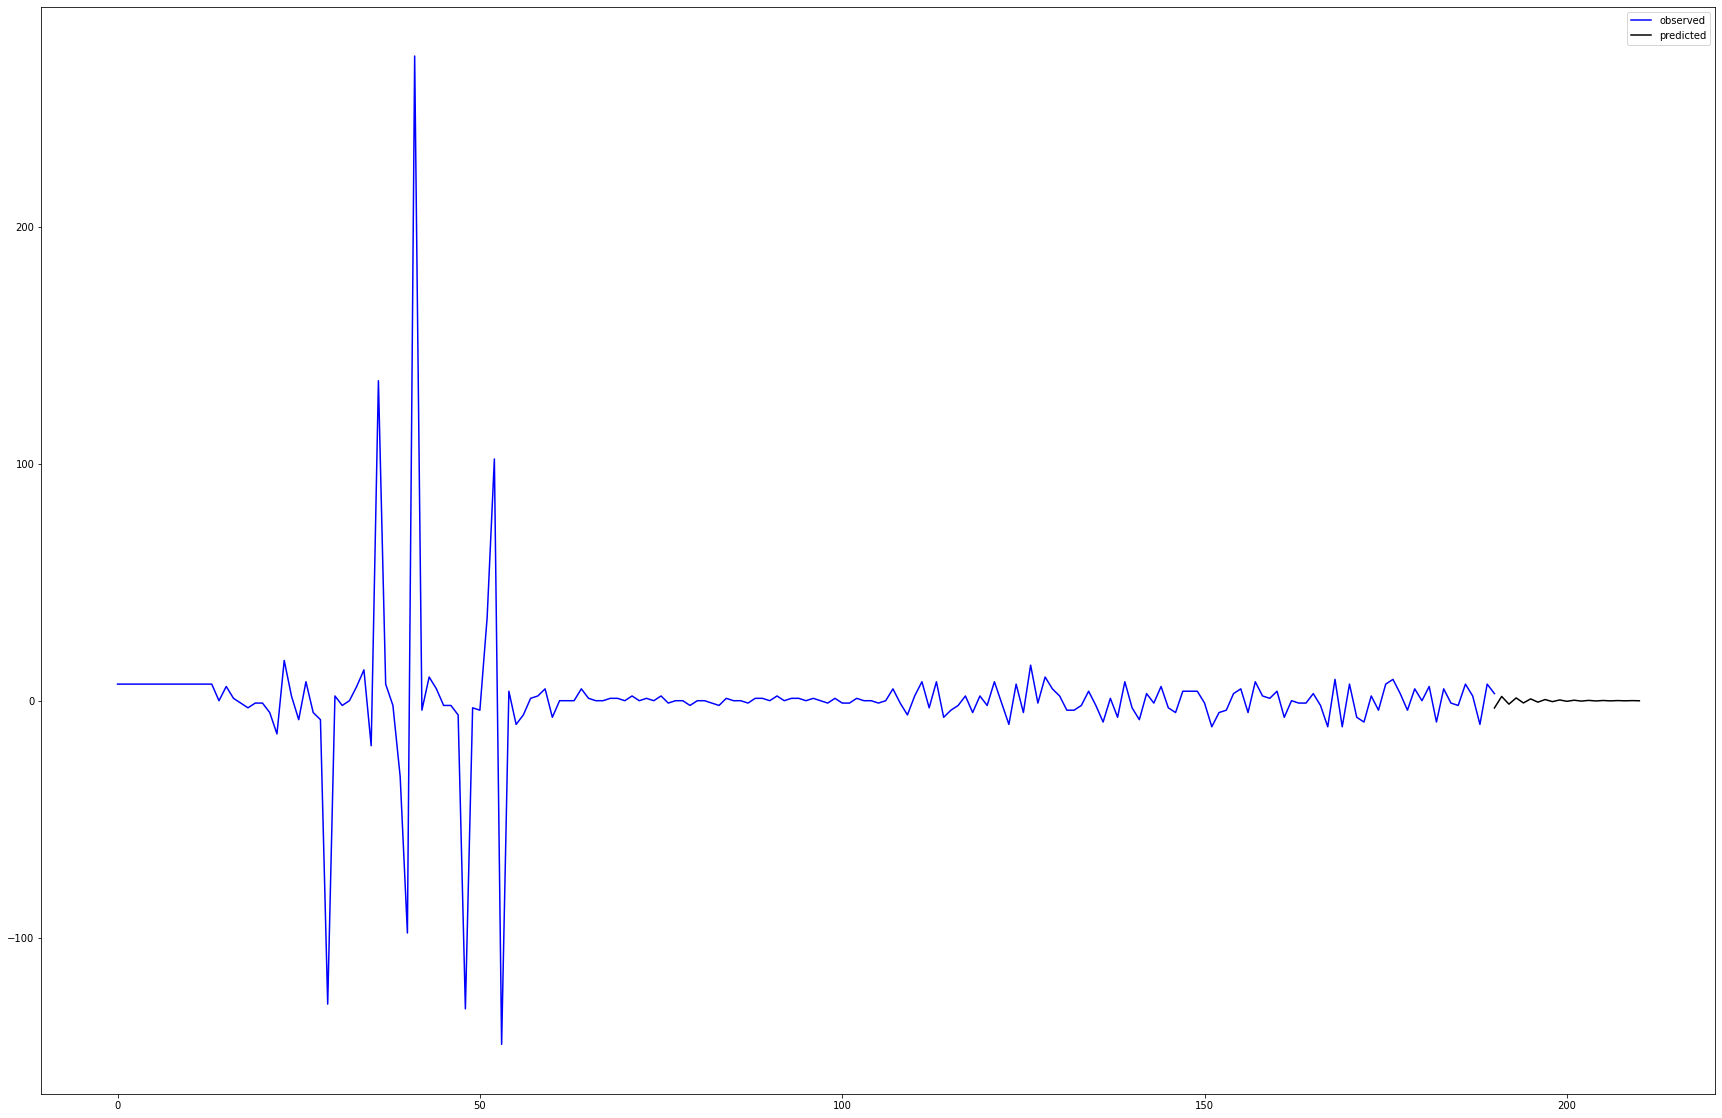

191   -3.069811
192    1.803592
193   -1.453982
194    1.172141
195   -0.944932
196    0.761766
197   -0.614105
198    0.495066
199   -0.399102
200    0.321740
201   -0.259373
202    0.209096
203   -0.168565
204    0.135890
205   -0.109549
206    0.088314
207   -0.071195
208    0.057395
209   -0.046269
210    0.037300
211   -0.030070
dtype: float64


NameError: ignored

In [17]:
# specify model - using above results 
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 2), #got from previous code results 
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
# fit model
results = mod.fit()
print(results.summary().tables[1])
# make predictions
pred = results.get_prediction(start=len(y),end=len(y)+20, dynamic=False) #The start is set to the end of y and the end is set 20 minutes after y 
pred_ci = pred.conf_int()

# plotting code
#ax = y.plot(label='observed', figsize=(20, 15))  #where i want to start plotting the data?
#pred.predicted_mean.plot(x=range(len(y),len(y)+20),ax=ax, label='One-step ahead Forecast', alpha=.7)

#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.plot(range(0,len(y)),y,color='b',label='observed')
y_forecasted = pred.predicted_mean
plt.plot(range(len(y)-1,len(y)+20),y_forecasted,color='k',label='predicted')

#plt.set_xlabel('Timestamp (GMT)')
#plt.set_ylabel('Lifetouch Heart Rate')
plt.legend()

plt.show()

print(y_forecasted) #printing the predicted next 20 miniutes of heart rate

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))